In [ ]:
# tensorflow 버전 확인
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# dataset 다운로드
from urllib.request import urlretrieve
urlretrieve('http://doc.mindscale.kr/km/unstructured/dog-vs-cat.zip','dog-vs-cat.zip')

# 압축파일 해제
from zipfile import ZipFile

with ZipFile('dog-vs-cat.zip') as z: 
    z.extractall()

In [ ]:
# dataset을 내 구글 드라이버로 이동시킴 
!mv dog-vs-cat /content/gdrive/My\ Drive/CV/Cats\ vs\ Dogs/

In [ ]:
# 다운로드 받았던 파일 제거
!rm dog-vs-cat.zip

In [ ]:
# 구글 드라이버로 이동된 dataset 확인
!ls /content/gdrive/My\ Drive/CV/Cats\ vs\ Dogs/dog-vs-cat/

train  validation


In [ ]:
# 필요한 패키지와 모듈을 불러옴
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
image_height = 150   # 이미지 높이
image_width = 150    # 이미지 넓이
batch_size = 10      # batch size
no_of_epochs  = 50   # training 횟수

In [ ]:
# ImageDataGenerator 클래스를 통해 train_datagen 인스턴스를 만듭니다.
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )

# train_datagen 인스턴스를 통해 trin dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 train_generator 객체를 생성한다.
train_generator = train_datagen.flow_from_directory(
    'gdrive/My Drive/CV/Cats vs Dogs/dog-vs-cat/train',
    batch_size=10,       # Size of the batches of data (default: 32).
    class_mode='binary', # Determines the type of label arrays that are returned. "categorical" will be 2D one-hot encoded labels, "binary" will be 1D binary labels, "sparse" will be 1D integer labels
    target_size=(image_width, image_height)) # 이미지의 크기 재정의
 
# ImageDataGenerator를 통해 validation dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_generator 객체를 생성한다.
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'gdrive/My Drive/CV/Cats vs Dogs/dog-vs-cat/validation',
    batch_size=10,
    class_mode='binary',
    target_size=(image_width, image_height))

# ImageDataGenerator를 통해 validation dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 pred_generator 객체를 생성한다.
pred_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'gdrive/My Drive/CV/Cats vs Dogs/dog-vs-cat/validation',
    batch_size=1,
    class_mode='binary',
    target_size=(image_width, image_height))

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
# train_generator 가 만들어 내는 이미지의 클래스 인덱스가 무엇인지 확인해 본다.

print(train_generator.class_indices)

{'cat': 0, 'dog': 1}


In [ ]:
# label name 을 찾아 오는 함수를 정의한다.
def findKey(indices, search_value):
    for key, value in indices.items():
        if(value == search_value):
            return key
    return -1

In [ ]:
# train dataset 에서 샘플 데이터를 display 해본다.
for X_batch, y_batch in ImageDataGenerator(rescale=1./255).flow_from_directory('gdrive/My Drive/CV/Cats vs Dogs/dog-vs-cat/train',
                                                                                batch_size=16, class_mode='binary', target_size=(150, 150)):
    plt.figure(figsize=(20,20))
    # create a grid of 4x4 images
    for i in range(0, 16):
        ax = plt.subplot(4, 4, i+1)
        ax.set_title(findKey(train_generator.class_indices, y_batch[i]))   # 이미지의 label name 을 찾아온다
        plt.imshow((X_batch[i].reshape(150, 150, 3)*255).astype(np.uint8)) # train 샘플 이미지를 보여준다.
    # show the plot
    plt.show()
    break

In [ ]:
# create model(모델을 만듭니다)

model = Sequential() 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height,image_width, 3))) 
model.add(MaxPooling2D((2, 2))) 
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2))) 
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2))) 
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2))) 
model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(512, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
# model training(모델을 학습시킵니다)
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=2000//batch_size, 
                    epochs=no_of_epochs, 
                    validation_data=test_generator, 
                    validation_steps=800//batch_size,
                    callbacks=[monitor_val_acc])   # 정확도를 모니터링하다가 증가되지 않고 떨어지거나 변화가 거의 없다면 patience 만큼 기다리다 학습을 중단함

Epoch 1/50
200/200 [==============================] - 19s 95ms/step - loss: 0.5311 - accuracy: 0.7410 - val_loss: 0.6113 - val_accuracy: 0.6562
Epoch 2/50
200/200 [==============================] - 19s 95ms/step - loss: 0.5289 - accuracy: 0.7325 - val_loss: 0.5341 - val_accuracy: 0.7387
Epoch 3/50
200/200 [==============================] - 19s 96ms/step - loss: 0.5160 - accuracy: 0.7435 - val_loss: 0.5774 - val_accuracy: 0.7063
Epoch 4/50
200/200 [==============================] - 19s 95ms/step - loss: 0.5184 - accuracy: 0.7325 - val_loss: 0.5509 - val_accuracy: 0.7325
Epoch 5/50
200/200 [==============================] - 19s 95ms/step - loss: 0.5193 - accuracy: 0.7445 - val_loss: 0.5419 - val_accuracy: 0.7362
Epoch 6/50
200/200 [==============================] - 19s 96ms/step - loss: 0.5262 - accuracy: 0.7370 - val_loss: 0.5182 - val_accuracy: 0.7525
Epoch 7/50
200/200 [==============================] - 19s 97ms/step - loss: 0.5214 - accuracy: 0.7425 - val_loss: 0.5113 - val_accuracy:

In [ ]:
# model evaluate(모델을 평가해 봅니다)
score = model.evaluate(test_generator, steps=800//batch_size, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Test loss: 0.5258832573890686
Test accuracy: 74.62499737739563


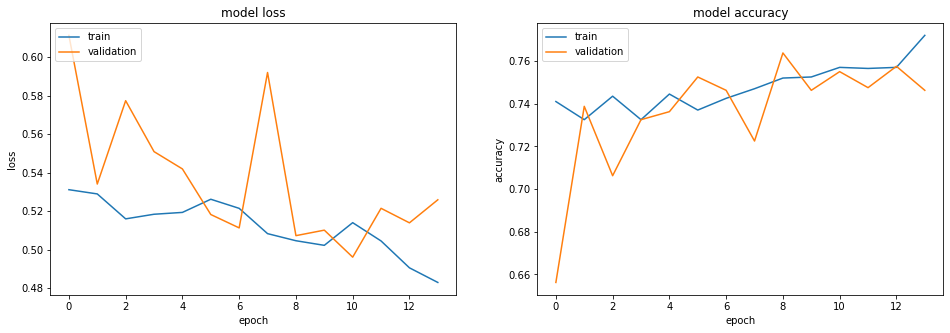

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
# 전체 모델을 H5 파일로 저장합니다.
model.save('Cats_vs_Dogs_model.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
# pred_generator 가 만들어낸 이미지를 우리가 만든 모델을 통해 분류 예측해 봅니다.
predictions = model.predict(pred_generator, steps=16, verbose=1)

16/16 [==============================] - 5s 334ms/step


In [ ]:
# predictions shape 확인
predictions.shape

(16, 1)

In [ ]:
# 예측결과 확인
predictions

array([[0.99999917],
       [0.76296943],
       [0.99421567],
       [0.18845145],
       [0.13816904],
       [0.86897916],
       [0.68544793],
       [0.4272314 ],
       [0.45582753],
       [0.6638954 ],
       [0.9446819 ],
       [0.8437484 ],
       [0.2521797 ],
       [0.6191652 ],
       [0.1957585 ],
       [0.75650483]], dtype=float32)

In [ ]:
# pred_generator 가 만들어 내는 이미지의 클래스 인덱스가 무엇인지 확인해 본다.
print(pred_generator.class_indices)

{'cat': 0, 'dog': 1}


In [ ]:
# Predict Result(pred_generator 가 만들어 낸 이미지를 우리가 만든 모델을 통해 예측한 결과를 보여줍니다.)
f,ax = plt.subplots(4,4,figsize=(20,20))

for i in range(len(predictions)):
    image, label = pred_generator.next()               # pred_generator 가 만들어 낸 이미지를 하나씩 꺼내온다
    real_class = 'cat' if int(label) == 0 else 'dog'   # pred_generator 가 만들어 낸 이미지의 label name 을 가져옴
    ax[i//4,i%4].imshow(image[0])                      # pred_generator 가 만들어 낸 이미지를 보여줌
    ax[i//4,i%4].axis('off')

    pred_class = 'dog' if predictions[i] > 0.5 else 'cat' # pred_generator 가 만들어 낸 이미지를 모델을 통해 예측한 결과 값의 label name
    pred_prob = predictions[i]                            # pred_generator 가 만들어 낸 이미지를 모델을 통해 예측한 결과(확률값)
    ax[i//4,i%4].set_title('REAL:' + real_class + '\nPREDICT:' + pred_class + '(' + str(pred_prob) + ')')  # title 에 실제값과 모델에 의해 예측된 예측값을 함께 보여준다.

f.suptitle('Predict Result')

plt.show()